![image](../QSS/Qulabs.png)

# Lab 3: Quantum teleportation and superdense coding

In this lab, you will learn to create `teleportation circuit`, `superdense coding` and how to simulates the circuits.

### Import necessary packages

At the begining, you will need to import some packgees into your notebook.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, transpile, IBMQ
from qiskit.visualization import plot_histogram
from qiskit.tools import job_monitor

In [2]:
# Load IBM account
if not IBMQ.active_account():
    IBMQ.load_account()
# Select provider
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# Select backend/ simulator
backend = provider.get_backend('ibmq_lima')
print(backend)
sim = provider.get_backend('ibmq_qasm_simulator')
print(sim)

ibmq_lima
ibmq_qasm_simulator


## QuantumCircuit

Let's explore `QuantumCircuit` once more.

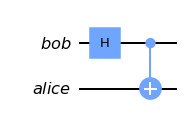

In [11]:
a_r = QuantumRegister(1, name = 'alice')
b_r = QuantumRegister(1, name = 'bob')
quant_crc = QuantumCircuit(b_r, a_r)
# Create Bell state
quant_crc.h(0)
quant_crc.cx(0, 1)
quant_crc.draw()

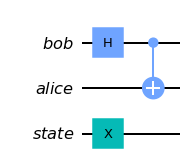

In [12]:
anc = QuantumRegister(1, 'state')
quant_crc.add_register(anc)
quant_crc.x(2)
quant_crc.draw()

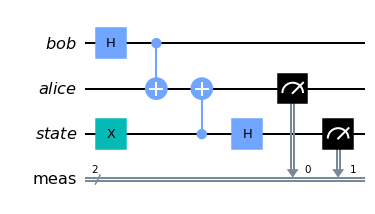

In [13]:
c_r = ClassicalRegister(2, name = 'meas')

quant_crc.add_register(c_r)

# Measure in Bell basis (Alice + ancilla)
quant_crc.cx(2, 1)
quant_crc.h(2)
quant_crc.measure([1, 2], [0, 1])
quant_crc.draw()

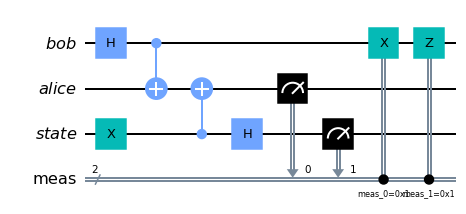

In [14]:
quant_crc.x(0).c_if(c_r[0], 1) # Apply gates if meas[0] output is 1
quant_crc.z(0).c_if(c_r[1], 1) # Apply gates if meas[1] output is 1

quant_crc.draw('mpl')

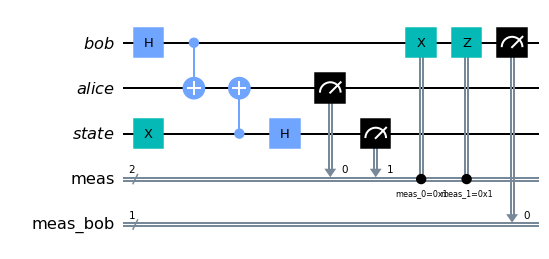

In [15]:
cb_r = ClassicalRegister(1, name = 'meas_bob')

quant_crc.add_register(cb_r)

quant_crc.measure(0, 2)
quant_crc.draw('mpl')

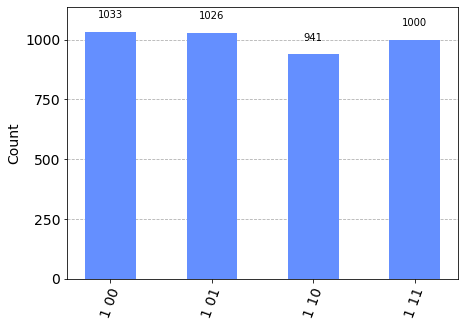

In [16]:
counts = execute(quant_crc, sim).result().get_counts()
plot_histogram(counts)

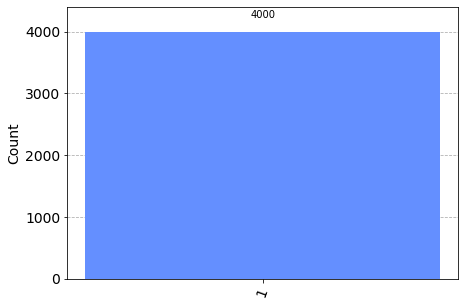

In [17]:
count = {}
for key in counts.keys():
    if key[0] not in count.keys():
        count[key[0]] = counts[key]
    else:
        count[key[0]] += counts[key]
plot_histogram(count)

## Quantum teleportation in real backend

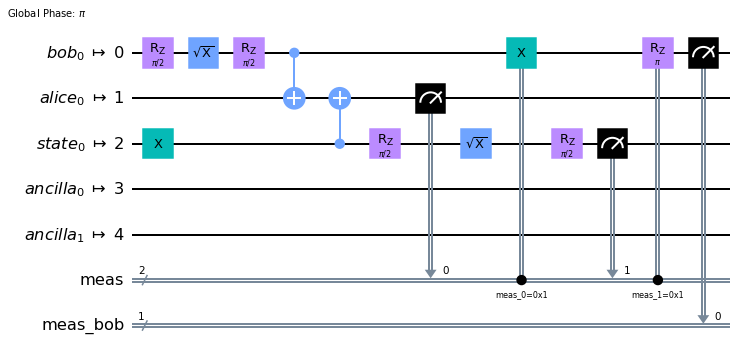

In [18]:
trans = transpile(quant_crc, backend)
trans.draw('mpl')

In [19]:
# Try it by yourself
result = backend.run(trans).result()

Traceback (most recent call last):
  Input In [19] in <cell line: 2>
    result = backend.run(trans).result()
  File /opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/job/ibmqjob.py:290 in result
    raise IBMQJobFailureError(
IBMQJobFailureError: 'Unable to retrieve result for job 638a2251c505e10d16657710. Job has failed: Instruction bfunc is not supported. Error code: 7001.'

Use %tb to get the full traceback.


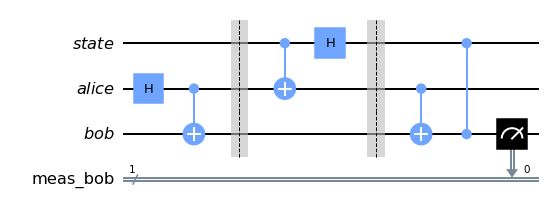

In [21]:
tel_crc = QuantumCircuit(anc, a_r, b_r, cb_r)
# Bell State preparation
tel_crc.h(1)
tel_crc.cx(1, 2)
# Bell measurement
tel_crc.barrier()
tel_crc.cx(0, 1)
tel_crc.h(0)
# tel_crc.measure([1, 2], [0, 0])
tel_crc.barrier()
# Apply gates on Bob's qubit
tel_crc.cx(1, 2)
tel_crc.cz(0, 2)
# Measure Bob's qubit
tel_crc.measure(2, 0)
tel_crc.draw('mpl')

In [22]:
tel_crc.remove_final_measurements()

from qiskit.quantum_info import DensityMatrix, partial_trace

DM = DensityMatrix.from_instruction(tel_crc)
print(DM.data)

PT = partial_trace(DM, [0, 1])
print('\n', PT.data)

print('\n', tel_crc)

[[0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]]

 [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

                   ░      ┌───┐ ░         
state: ───────────░───■──┤ H ├─░───────■─
       ┌───┐      ░ ┌─┴─┐└───┘ ░       │ 
alice: ┤ H ├──■───░─┤ X ├──────░───■───┼─
       └───┘┌─┴─┐ ░ └───┘      ░ ┌─┴─┐ │ 
  bob: ─────┤ X ├─░────────────░─┤ X ├─■─
            └───┘ ░            ░ └───┘   


# Assignment
#### Read the instructions carefully. You are NOT ALLOWED to make any change outside the instructed place.
#### Naming format for the submitted file should be Lab3_\<Your_Name\>.ipynb. If you use any other format that submission will not be considered!!!

# Lab - 3 Assignment - 1 [5 (2+.5+.5+1+1) Points]

In [33]:
def teleportation(r1, r2, r3):
    
    '''Perform teleportation considering r2 as the initial state
    and r3 as the register where final state to be produced'''
    
    tel_crc = QuantumCircuit(r2, r1, r3)
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    # Bell State preparation
    tel_crc.h(r3) 
    tel_crc.cx(r3,r1)
    # Bell measurement
    tel_crc.barrier()
    tel_crc.cx(r2, r1)
    tel_crc.h(r2)
    # Apply gates on Bob's qubit
    tel_crc.cx(r1, r3)
    tel_crc.cz(r2, r3)
    # Measure Bob's qubit
    #tel_crc.measure(r3, r1)
    #tel_crc.draw('mpl')
            
    ### WRITE YOUR CODE BETWEEN THESE LINES - END
    tel_crc.remove_final_measurements()
    return tel_crc

In [47]:
### imports
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

### set up the qubits and classical bits
alice = QuantumRegister(1, name = 'alice')
bob0 = QuantumRegister(1, name = 'bob0')
bob1 = QuantumRegister(1, name = 'bob1')
charlie = QuantumRegister(1, name = 'charlie')

ghz = QuantumCircuit(alice, bob0, bob1, charlie)

### WRITE YOUR CODE BELLOW ACCORDING TO THE GIVEN INSTRUCTIONS
# Create |Φ+⟩ state between alice and bob0
ghz.h(0)
ghz.cx(0,1)

ghz.barrier()
# Create |Φ+⟩ state between bob1 and charlie
ghz.h(2)
ghz.cx(2,3)

ghz.barrier()
### NOTE THAT THERE IS NO ENTANGLEMENT BETWEEN ALICE AND CHARLIE
ghz.append(teleportation(bob1, bob0, charlie), [1, 2, 3])   ### DO NOT MAKE ANY CHANGE HERE
# Trace out bob0 and bob1 and print the partial trace ONLY

DM = DensityMatrix.from_instruction(ghz)
print(DM.data)

PT = partial_trace(DM, [0, 1])

print('\n', PT.data)
print('\n', ghz)

# DON'T TOUCH BELOW
print('\n', ghz.decompose())

[[ 0.0625+0.j  0.0625+0.j  0.0625+0.j -0.0625+0.j  0.0625+0.j -0.0625+0.j
   0.0625+0.j  0.0625+0.j -0.0625+0.j  0.0625+0.j  0.0625+0.j  0.0625+0.j
   0.0625+0.j  0.0625+0.j -0.0625+0.j  0.0625+0.j]
 [ 0.0625+0.j  0.0625+0.j  0.0625+0.j -0.0625+0.j  0.0625+0.j -0.0625+0.j
   0.0625+0.j  0.0625+0.j -0.0625+0.j  0.0625+0.j  0.0625+0.j  0.0625+0.j
   0.0625+0.j  0.0625+0.j -0.0625+0.j  0.0625+0.j]
 [ 0.0625+0.j  0.0625+0.j  0.0625+0.j -0.0625+0.j  0.0625+0.j -0.0625+0.j
   0.0625+0.j  0.0625+0.j -0.0625+0.j  0.0625+0.j  0.0625+0.j  0.0625+0.j
   0.0625+0.j  0.0625+0.j -0.0625+0.j  0.0625+0.j]
 [-0.0625+0.j -0.0625+0.j -0.0625+0.j  0.0625+0.j -0.0625+0.j  0.0625+0.j
  -0.0625+0.j -0.0625+0.j  0.0625+0.j -0.0625+0.j -0.0625+0.j -0.0625+0.j
  -0.0625+0.j -0.0625+0.j  0.0625+0.j -0.0625+0.j]
 [ 0.0625+0.j  0.0625+0.j  0.0625+0.j -0.0625+0.j  0.0625+0.j -0.0625+0.j
   0.0625+0.j  0.0625+0.j -0.0625+0.j  0.0625+0.j  0.0625+0.j  0.0625+0.j
   0.0625+0.j  0.0625+0.j -0.0625+0.j  0.0625+0.j]
 [-0.

ONLY enter the elements of the sv vector in the following cell. DO NOT make any other change.

In [56]:
# Print  (use array_to_latex)
# NOTE THAT THIS IS THE STATE VECTOR BETWEEN ALICE CHARLIE
# SO ALICE AND CHARLIE ARE NOW ENTANGLED!!!
from qiskit.visualization import array_to_latex
from numpy import tensordot
import math
import numpy as np

sv = [[0.25+0.j,0.+0.j,0.+0.j,0.+0.j],[0.+0.j,0.25+0.j,0.+0.j,0.+0.j],[0.+0.j,0.+0.j,0.25+0.j,0.+0.j],[0.+0.j,0.+0.j,0.+0.j,0.25+0.j]] # complete the state vector corresponding to the partial trace above
display(array_to_latex(sv, prefix='\\text{Statevector = }'))
DM = tensordot(sv, sv, 0)
print(DM) # this should be same as above partial trace

<IPython.core.display.Latex object>

[[[[0.0625+0.j 0.    +0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.0625+0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.0625+0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.    +0.j 0.0625+0.j]]

  [[0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]]

  [[0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]]

  [[0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]]]


 [[[0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]
   [0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j]]

  [[0.06

# Superdense Coding

Here you have to send a classical message from Alice's end to Bob's end using shared entanglement. You have to perform the following:

1. Creation of entanglement between Alice and Bob (one qubit belongs to Alice, another to Bob).
2. Alice applies single-qubit gates as required.
3. Alice sends her qubit to Bob (This step is not possible in qiskit).
4. Bob applies Bell measurement to collect result.

To perform this fill the gaps in following cells.

# Lab - 3 Assignment - 2 [5 (1+2+2) Points]

### Initializing the state to be teleported

In [50]:
def entangle_qubits(given_circuit, qubit_Alice, qubit_Bob):
    
    '''Creates required entanglement between Alice and Bob's register
    qubit_Alice and qubit_Bob are Alice and Bob's register respectively in given_circuit'''
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    qubit_Alice = QuantumRegister(1)
    qubit_Bob = QuantumRegister(1)
    cqubit = ClassicalRegister(2)
    given_circuit = QuantumCircuit(qubit_Alice, qubit_Bob, cqubit)
    given_circuit.h(qubit_Alice)
    given_circuit.cx(qubit_Alice, qubit_Bob)
    
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END
    given_circuit.barrier()
    return given_circuit

In [51]:
def apply_gates(given_circuit, qubit, message):
    
    '''Apply single-qubit gates (x if mesage is [0, 1] or [1, 1]and z if message is [1, 0] or [1, 1]) as required
    qubit is the register where single-qubit gates to be applied
    and message is a list containing two binary values'''
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START

    if message[1] == 1:
        given_circuit.x(qubit)
    if message[0] == 1:
        given_circuit.z(qubit)
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END
    given_circuit.barrier()
    return given_circuit

Next, there will be Bell measurement [Note that now both the qubits belong to Bob].

In [52]:
def bell_meas_Bob_qubits(given_circuit, qubit1_Bob, qubit2_Bob):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES (DO NOT ADD MEASUREMENT) - START
    given_circuit.cx(qubit1_Bob,qubit2_Bob)
    given_circuit.h(qubit1_Bob)

    ### WRITE YOUR CODE BETWEEN THESE LINES - END
    given_circuit.barrier()
    return given_circuit

The next lines of code puts everything together. [LEAVE AS IT IS]

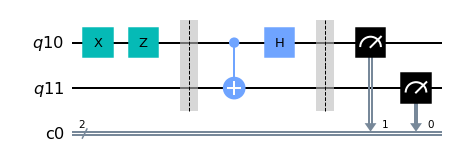

In [53]:
### imports
from qiskit import QuantumRegister, ClassicalRegister
from numpy.random import randint

### set up the qubits and classical bits
Alice_reg = QuantumRegister(1)
Bob_reg = QuantumRegister(1)
meas = ClassicalRegister(2)

# Generate a 2-bit classical message as an array of size 2
message = randint(2, size = 2)

### quantum teleportation circuit here
# Create Quantum Cirtuit
mycircuit = QuantumCircuit(Alice_reg, Bob_reg, meas)
# Create Bell state
entangle_qubits(mycircuit, Alice_reg, Bob_reg)
# Apply quantum gates
apply_gates(mycircuit, Alice_reg, message)
# Measure in Bell basis
bell_meas_Bob_qubits(mycircuit, Alice_reg, Bob_reg)
mycircuit.measure([0, 1], [1, 0])
### Look at the complete circuit
mycircuit.draw()

Run above circuit and plot histogram. Also print message. In histogram message should be there with probability 1.

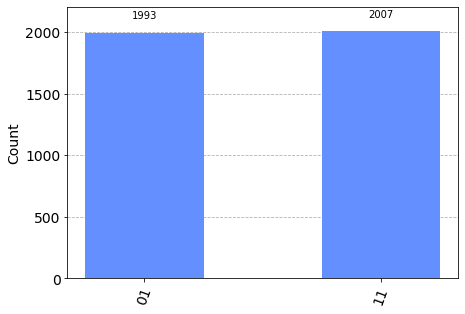

In [54]:
plot_histogram(execute(mycircuit, sim).result().get_counts())

In [55]:
print(message)

[1 1]
